CNN model inspired by AlexNet model

In [51]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import Dataset
import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam

from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn import metrics

import os
from collections import Counter
from helpers import *

1. Load the dataset 

In [52]:
#load training data (will be put in a function later)  
path = os.getcwd()
for i in range(3) :

    path = os.path.dirname(path)

path += '/data/'
train_df = pd.read_csv(path + 'train_v1.csv',index_col="seq_id")
train_df = train_df.drop(columns=['data_source'])
train_df = train_df.dropna()
train_df.head()

,protein_sequence,pH,tm
seq_id,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5


In [53]:
test_df = pd.read_csv(path+ 'test.csv',index_col='seq_id')
test_df = test_df.drop(columns=['data_source'])
test_df['length'] = test_df['protein_sequence'].str.len()

2. One-hot encoding of the sequence

In [54]:
#add a new column that contains the length of each protein sequence (before padding)
train_df['length'] = train_df['protein_sequence'].str.len()

In [55]:
# fix max_length to be 500
max_length = 500

#drop rows that exceeds this value

train_df = train_df[train_df['length'] < max_length]



In [56]:
# new column with encoded sequence (apply for each sequence)
train_df['encoded_sequence'] = train_df['protein_sequence'].apply(lambda x: encode_seq(x, max_length))
test_df['encoded_sequence'] = test_df['protein_sequence'].apply(lambda x: encode_seq(x, max_length))

In [57]:
#final dataframe 
train_df.head()

,protein_sequence,pH,tm,length,encoded_sequence
seq_id,,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,"[[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0,..."
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,"[[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,"[[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,"[[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
5,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,48.4,380,"[[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [58]:
df = train_df.copy()

In [59]:
df = df.reset_index(drop=True)

In [60]:
test_df = test_df.reset_index(drop=True)

Split to train and validation sets

In [61]:
train_df , val_df = split_train_test(df,frac=0.8)

train_df has shape : (16408, 5) 
 test_df has shape :  (4102, 5)


3. Model: CNN + MLP

In [62]:
class EnzymesDataset(Dataset):
 
    def __init__(self,df,train=True):
    
        # the Amino acid sequences as an int array
        sequence= df['encoded_sequence']
        # numerical : pH and length
        numerical = df[['pH','length']].values

        # y : the target (tm)
        if train == True : 
            y=df['tm'].values
        else : 
            y = np.zeros(len(sequence))
        self.y=torch.tensor(y,dtype=torch.float32)
        #creta tensors from the numpy arrays
        self.x_sequence=torch.tensor(sequence)
       
        self.num=torch.tensor(numerical,dtype=torch.float32)
   
 
    def __len__(self):
        return len(self.y)
   
    def __getitem__(self,idx):
        return self.x_sequence[idx],self.y[idx] , self.num[idx]


In [63]:
# hyperparameters
batch_size = 64
learning_rate = 0.001 # Suggested for Adam
num_epochs = 100


In [64]:
# create pytorch dataframes
train_d = EnzymesDataset(train_df)
val_d = EnzymesDataset(val_df)


# create pytorch dataloaders
train_dl = torch.utils.data.DataLoader(train_d, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_d, batch_size=batch_size, shuffle=True)

In [65]:
class AlexNet(nn.Module):

    def __init__(self):
        super().__init__()
       
        self.prot_seq_one_pooling = nn.Sequential(


            nn.Conv1d(in_channels=20, out_channels=30, kernel_size=11, stride=4),  # (b x 96 x 55 x 55)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),  # section 3.3
            nn.MaxPool1d(kernel_size=3, stride=2),  # (b x 96 x 27 x 27)
            nn.Conv1d(30, 30, 5, padding=2),  # (b x 256 x 27 x 27)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool1d(kernel_size=3, stride=2),  # (b x 256 x 13 x 13)
            nn.Conv1d(30, 30, 3, padding=1),  # (b x 384 x 13 x 13)
            nn.ReLU(),
            nn.Conv1d(30, 30, 3, padding=1),  # (b x 384 x 13 x 13)
            nn.ReLU(),
            nn.Conv1d(30, 10, 3, padding=1),  # (b x 256 x 13 x 13)
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2),  # (b x 256 x 6 x 6)
            torch.nn.Flatten(),

            

        )
        self.numerical = nn.Sequential(
            nn.Linear(2, 2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2, 2),
            nn.ReLU(),
            
        )
        
        
        self.mlp = nn.Sequential(
            nn.Linear(142, 128),#input devrait être 32 + 64 plutôt non si on utilise MaxPoolId(2)? (était marqué 128 en input avant) Comme on fait le pooling
            nn.ReLU(),
 
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            
            
        )

    def forward(self, x,y):
        
        x = self.prot_seq_one_pooling(x.float())
       
        y = self.numerical(y)
       
        x = torch.cat((x.squeeze(1), y), 1)
      
        x = self.mlp(x)
        return x

In [66]:
model = AlexNet()
optimizer = Adam(model.parameters(), lr=learning_rate)
# defining the loss function
criterion = nn.MSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()


4. Cross validation

from sklearn.model_selection import KFold


k_folds = 5
learning_rate = 1e-4
kfold = KFold(n_splits=k_folds, shuffle=True)
dataset = EnzymesDataset(df.reset_index(drop=True))
train_loss_history = []
test_loss_history = []
train_rho_history = []
test_rho_history = []
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    train_dl = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=32, sampler=train_subsampler)
    val_dl = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=32, sampler=test_subsampler)

    model = Conv1D_OneChannel()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    # defining the loss function
    criterion = nn.MSELoss()
    # checking if GPU is available
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
    
    for epoch in range(1, num_epochs + 1):
        train_loss , rho_train = train_epoch( model, optimizer, criterion, train_dl, epoch)
       

        
    
    
    test_loss , rho_test = test_epoch(model, criterion, val_dl)
        

    train_loss_history.append(train_loss)
    train_rho_history.append(rho_train)
    test_loss_history.append(test_loss)
    test_rho_history.append(rho_test)

    
    
    print(f'for fold {fold} : \n train_loss :  {train_loss}     test_loss : {test_loss} \n \n')
    
    
    
 


5. Train the model and create plots

In [67]:
# train and test the model (save it after each epoch)
train_loss_history = []
test_loss_history = []
train_rho_history = []
test_rho_history = []
for epoch in range(1, num_epochs + 1):
    train_loss , rho_train = train_epoch(
        model, optimizer, criterion, train_dl, epoch
    )
    train_loss_history.append(train_loss)
    train_rho_history.append(rho_train)

    
    test_loss , rho_test = test_epoch(model, criterion, val_dl)
    test_loss_history.append(test_loss)
    test_rho_history.append(rho_test)
    
#torch.save(model.state_dict(), f"3-Less_Channels.pth")

Test set: Average loss: 1.40e+02 
Test set: Average loss: 1.25e+02 
Test set: Average loss: 1.17e+02 
Test set: Average loss: 1.18e+02 
Test set: Average loss: 1.11e+02 
Test set: Average loss: 1.02e+02 
Test set: Average loss: 1.03e+02 
Test set: Average loss: 1.02e+02 
Test set: Average loss: 9.86e+01 
Test set: Average loss: 1.03e+02 
Test set: Average loss: 9.86e+01 
Test set: Average loss: 1.00e+02 
Test set: Average loss: 9.87e+01 
Test set: Average loss: 1.00e+02 
Test set: Average loss: 1.06e+02 
Test set: Average loss: 1.09e+02 
Test set: Average loss: 1.03e+02 
Test set: Average loss: 1.04e+02 
Test set: Average loss: 1.09e+02 
Test set: Average loss: 1.05e+02 
Test set: Average loss: 1.08e+02 
Test set: Average loss: 1.10e+02 
Test set: Average loss: 1.11e+02 
Test set: Average loss: 1.08e+02 
Test set: Average loss: 1.13e+02 
Test set: Average loss: 1.16e+02 
Test set: Average loss: 1.13e+02 
Test set: Average loss: 1.15e+02 
Test set: Average loss: 1.15e+02 
Test set: Aver

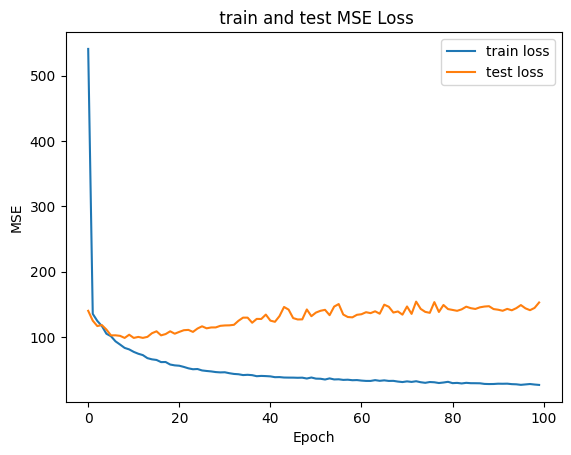

In [68]:
#create loss plot

plt.plot(train_loss_history, label='train loss')
plt.plot(test_loss_history, label='test loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title(' train and test MSE Loss')
plt.legend()
plt.savefig('5_AlexNet_Loss.png')


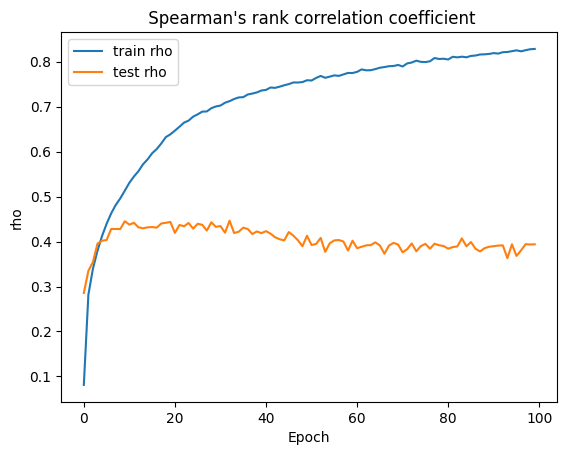

In [69]:
plt.plot(train_rho_history, label='train rho')
plt.plot(test_rho_history, label='test rho')
plt.xlabel('Epoch')
plt.ylabel('rho')
plt.title(' Spearman\'s rank correlation coefficient')
plt.legend()
plt.savefig('5_alex_net_rho.png')

6. Kaggle prediction

In [70]:
#Prediction for Kaggle's submission
test_d = EnzymesDataset(test_df, False)

# create pytorch dataloaders
sub_dl = torch.utils.data.DataLoader(test_d, batch_size=batch_size, shuffle=True)
submission_df =  predict(model,sub_dl)


In [71]:
submission = pd.read_csv(path+ 'test.csv',index_col='seq_id')
submission['tm']=submission_df
submission = submission.drop(columns=['protein_sequence','pH','data_source'])
#test_sub.to_csv('5-AlexNet.csv', index=True)